# wikiHow: Topic Modelling and Analysis

[wikiHow](https://www.wikihow.com/Main-Page) is a popular online encyclopedia featuring how-to guides across a variety of different topics. This project uses a [Kaggle](https://www.kaggle.com/datasets/elfarouketawil/wikihow-featured-articles) dataset containing around 1,000 featured articles. Each row contains the articles title, introduction paragraph and full article contents. Additionally, we have information about other details such as number of views and authors. is a popular online encyclopedia featuring how-to guides across a variety of different topics.


The aim of this anaylsis is to group articles together into similar topics using various NLP and unsupervised machine learning techniques like k-means clustering and NMF. After this, the different characteristics and popularity of each topic can be examined. Finally, we will calculate the pairwise cosine similarity for each vectorized article. We will use this information to construct a graph network with each node being an article and edges linking articles with high semantic similarity. We can then identify relatively important articles in the network and gain more insight into how information is organized in the encyclopedia.

This framework has many practical purporse. It can be used to optimize large corpora for NLP tasks, knowledge base management or ciriculum design by identifing redundant aricles and structural gaps in topic maps.

## Part 1: Introduction and Vectorization

In the first part of this project, we will load and explore the data, preprocess the text by tokenizing, removing stop words and stemming. Next we will apply TF-IDF vectorization, and finally reduce the dimensionality using truncated SVD.

**Input**: <code>../raw/data/input/articles.csv</code>

**Output**: <code>../data/models/svd_matrix.npy</code> and <code>../data/processing/01_modified_df.csv</code>


### Introduction
First, load the dataset as a Pandas dataframe and examine the structure of the data:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# NLTK modules:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
# For vectorizing:
from sklearn.feature_extraction.text import TfidfVectorizer
# For SVD:
from sklearn.decomposition import TruncatedSVD


full_df = pd.read_csv("../data/input/articles.csv")
full_df.head()

,Title,Intro,Article Content,Co-authors,Updated,Views
0,How to Perform the Tahajjud Prayer,The Tahajjud is a special Islamic night prayer...,Arrange to wake up after midnight. After prayi...,60,"Updated: March 21, 2023",5638718
1,How to Take a Screenshot on a Windows PC: 8 Si...,Need to take a screenshot on your Windows PC? ...,Go to the screen that you want to capture. Whe...,321,"Updated: April 15, 2023",35602414
2,How to Play Poker,\nLooking to learn basic poker rules? Poker’s ...,Learn the 10 basic 5-card hands and their rank...,229,"Updated: April 12, 2023",7598092
3,How to French Kiss,\nYou've seen it done in the movies and probab...,"Keep your lips soft. A soft, smooth, and sligh...",287,"Updated: December 13, 2022",27872519
4,How to Kiss,"\nSo you finally got ""the look"" and you're mov...",Drop hints that you're interested. You can put...,309,"Updated: April 8, 2023",33291709


Initial examination shows the structure of the dataset. From the first 5 rows, we can already see that the topics are quite varied.  

In [2]:
full_df.shape

(997, 6)

There are 997 different articles and six different columns:
<ul>
    <li><b>Title</b>: article title</li>
    <li><b>Intro</b>: introduction</li>
    <li><b>Article Content</b>: contents of the article</li>
    <li><b>Co-authors</b>: number of authors</li>
    <li><b>Updated</b>: the date of the most recent update</li>
    <li><b>Views</b>: number of views</li>
</ul>
Add an <code>Article_Id</code> column to uniquely identify every row:

In [3]:
full_df["Article_Id"] = full_df.index + 1

# reorganize columns, dropping Updated
full_df = full_df[["Article_Id", "Title", "Intro", "Article Content", "Co-authors", "Views"]]

The first stage is to transform the text into the dataframe from human language into something that can be interpreted by a computer.

We can simplify the dataset by concatenating <code>Intro</code> to <code>Article Content</code> and naming the resulting column simply <code>Article</code>:

In [4]:
full_df["Article"] = full_df["Intro"] +  " " + full_df["Article Content"]

### Vectorization
Vectorization can transform a document into an n-dimensional vector, where n is the number of unique words (or grams) in the corpus. These vectors can simply be the frequency of each word in the document (bag of words approach) or weighted in a way that gives relatively rare words in the corpus more significance when they appear in a particulary document (Term frequency inverse document frequency or tf-idf).

Create a new dataframe only containing the article text and titles columns:

In [5]:
df_text = full_df.drop(columns=["Co-authors", "Intro", "Article Content", "Views"], axis=1)
df_text.head()

,Article_Id,Title,Article
0,1,How to Perform the Tahajjud Prayer,The Tahajjud is a special Islamic night prayer...
1,2,How to Take a Screenshot on a Windows PC: 8 Si...,Need to take a screenshot on your Windows PC? ...
2,3,How to Play Poker,\nLooking to learn basic poker rules? Poker’s ...
3,4,How to French Kiss,\nYou've seen it done in the movies and probab...
4,5,How to Kiss,"\nSo you finally got ""the look"" and you're mov..."


#### Preprocessing
Preprocessing the text is the first step in changing it from unstructured data to a form that can be understood by machine learning algorithms. In this case, preprocessing will consist of three steps: word tokenization, stop word removal and stemming. Each of these steps make up a preprocessing pipeline.

##### Tokenization
Tokenization is the process of spliting up a piece of text into smaller discrete elements known as tokens. Here, the Natural Language Toolkit (NLTK) word tokenizer is used to split each of the articles into a list of individual words and punctuation.

In [6]:
article_tokenized = [word_tokenize(t) for t in df_text["Article"]]

##### Stop words
Stop words are frequently occurring words that provide syntactic structure but contain little lexical meaning such as pronouns or conjunctions. Stop words should be removed to reduce noise and meaningless features in the vectorized data. Stop words are removed using the NLTK list of English stop words.

In [7]:
stop_words = set(stopwords.words('english'))
filtered_article = [[t.lower() for t in doc if t.lower() not in stop_words] for doc in article_tokenized]

##### Stemming
The final step in preprocessing is stemming. Stemming reduces inflected forms of words into their base form (stem) by removing the affixes. Because of how it works, stemming can sometimes result in stems that are not real words (for example, "babies" stems to "babi"). For this reason stop words are removed before stemming. Another limitation of stemming is that irregular plurals do not get stemmed (for example: "men"). Lemmatization reduces words to their lemma form, but it requires parts of speech to be attached to the words.

Stem the words with NLTK PorterStemmer:

In [8]:
stemmer = PorterStemmer()
stemmed_article = [[stemmer.stem(t) for t in doc] for doc in filtered_article]

After preprocessing the text, add it to the dataframe and convert from a list to a string:

In [9]:
df_text["Processed Article"] = stemmed_article
df_text["Processed Article"] = df_text["Processed Article"].apply(lambda x: " ".join(x))

Now that the text has been fully processed, we don't need the original article text.

Drop the unprocessed article text, leaving just the Title and Processed Article text, and examine the new columm:

In [10]:
df_text = df_text.drop(columns="Article", axis=1)
df_text.head()

,Article_Id,Title,Processed Article
0,1,How to Perform the Tahajjud Prayer,tahajjud special islam night prayer recommend ...
1,2,How to Take a Screenshot on a Windows PC: 8 Si...,need take screenshot window pc ? whether want ...
2,3,How to Play Poker,look learn basic poker rule ? poker ’ incred p...
3,4,How to French Kiss,'ve seen done movi probabl even public—th fren...
4,5,How to Kiss,final got `` look '' 're move killer kiss dawn...


### TF-IDF
**TF-IDF** (or Term Frequency-Inverse Document Frequency) is a measure of how important a word is in a document in a corpus (a collection of documents). It is a combination of the **Term Frequency**, how often a word appears in a given document, and the **Inverse Document Frequency**, how rare a word is in the corpus as a whole. Term Frequency is multiplied by Inverse Document Frequency to give a final score for each word. This techique is useful because it emphasises the differences between the articles in a corpus that may share significant amounts of vocabulary.

Vectorize <code>Processed Article</code> using sklearn's tf-idf vectorizer. The parameters are set to include single words and also common pairs of words (n-grams of 1 and 2). This allows collocations and other pairs of words that may have different semantics when taken separately (for example, phrasal verbs). Furthermore, any gram with a low or high relative frequency will be excluded. This will help to reduce the number of features and noise in the model. Punctuation will automatically be filtered out. The TF-IDF vectorizer fits to the data and transforms it in one step.

In [11]:
vectorizer_article = TfidfVectorizer(ngram_range=(1,2), min_df=0.1, max_df=0.95)
tfidf_article = vectorizer_article.fit_transform(df_text["Processed Article"])

In [12]:
print("and" in df_text["Processed Article"])

False


Create a dataframe using the generated tf-idf matrix with the feature names as the columns:

In [13]:
article_features = vectorizer_article.get_feature_names_out()
vect_article_df = pd.DataFrame(tfidf_article.toarray(), columns=article_features)

This creates the vectorised article dataframe containing 713 features and 997 rows each corresponding to the original articles.

We can briefly examine this dataframe:

In [14]:
vect_article_df.head()

,10,100,12,15,20,30,abl,access,account,across,...,work,world,worri,would,wrap,write,wrong,www,year,yet
0,0.000000,0.000000,0.0,0.0,0.000000,0.019086,0.045500,0.000000,0.0,0.00000,...,0.036421,0.000000,0.044704,0.017088,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,0.028565,0.008783,0.0,0.0,0.000000,0.012485,0.000000,0.008471,0.0,0.00000,...,0.003971,0.000000,0.000000,0.005589,0.000000,0.000000,0.000000,0.008979,0.0,0.000000
2,0.040439,0.000000,0.0,0.0,0.020505,0.017675,0.014046,0.000000,0.0,0.00000,...,0.000000,0.000000,0.000000,0.039562,0.000000,0.000000,0.000000,0.000000,0.0,0.024542
3,0.000000,0.000000,0.0,0.0,0.014371,0.012388,0.019688,0.016810,0.0,0.00000,...,0.007880,0.017669,0.029015,0.011091,0.014851,0.014591,0.017718,0.000000,0.0,0.000000
4,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031923,0.000000,0.0,0.03101,...,0.008518,0.038200,0.015682,0.011989,0.000000,0.015773,0.000000,0.000000,0.0,0.018593


### Truncated SVD
SVD (Single Value Decomposition) is a technique that can reduce the dimensionality of a sparse (where most elements are zero) tf-idf matrix, like the one we have created. It works by decomposing the matrix into three component matrices thereby reducing the dimensionality while preserving the most important features. This reduces noise and improves the efficiency of subsequent machine learning algorithms such as k-means clustering. By applying SVD to the tf-idf matrix, we can obtain a lower-dimensional representation that captures the essential information needed for clustering.



**Note:** SVD can also be used directly for topic modelling where the number of topic corresponds to the number of components. Articles can then be assigned a topic (or potentially more) based on the SVD component (or components) they score highest in. Topic names can be determined by looking at the terms with the highest weights for each component. This is similar to the workflow for non-negative matrix factorization (NMF). However, in this case where the number of topics is still unknown, SVD is used as a means to reduce the dimensionality of the matrix in preparation for k-means clustering in a similar way to principal component analysis (PCA).

#### Number of components
Reducing the dimensionality of a matrix with SVD also reduces the amount of explained variance. For most purposes, an explained variance of about 80 to 90% is adequate. Plot the amount of explained variance against the number of components to determine how many components are necessary.


In [15]:
svd = TruncatedSVD(n_components=713, random_state=2)
svd_matrix = svd.fit_transform(vect_article_df)

explained_variance = svd.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

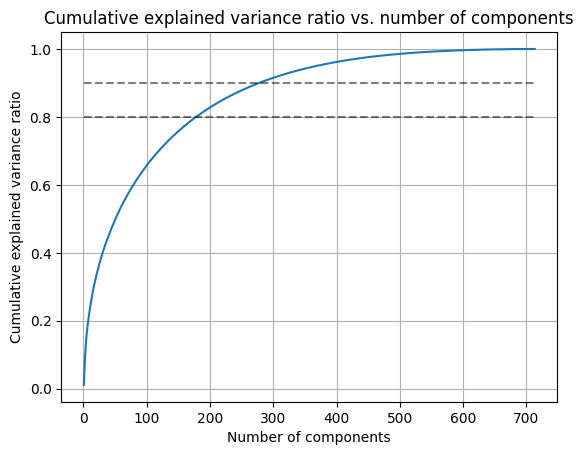

In [16]:
fig, ax = plt.subplots()
x = range(1, 714)
ax.plot(x, cumulative_variance)
ax.set(
        title="Cumulative explained variance ratio vs. number of components",
        xlabel="Number of components",
        ylabel="Cumulative explained variance ratio",
      )
ax.plot(x, np.ones_like(x) * 0.8, "--", color="black", alpha=0.5)
ax.plot(x, np.ones_like(x) * 0.9, "--", color="black", alpha=0.5)
ax.grid()
plt.show()

From the graph above, the desired interval of 80-90% of cumulative explained variance is found at between 180 and 280 components. After this point, explained variance levels off. When 194 components are chose, 81.9% of the variance is explained. This greatly reduces the features in the dataset while preserving a large proprotion of explained variance.

In [17]:
svd = TruncatedSVD(n_components=194, random_state=2)
svd_matrix = svd.fit_transform(vect_article_df)
svd_matrix.shape

(997, 194)

Using SVD, we have reduced the number of features in the dataset from 713 to 194 while still conserving over 82% of the explained variance. This reduction in dimension will improve the efficiency for the next stages.

### Summary

In the first stage of this project, we:
<ul>
    <li>Imported the original Wikihow data.</li>
    <li>Preprocessed the text by tokenizing, removing stop words, and stemming.</li>
    <li>Calculated the TF-IDF for each article in the dataset.</li>
    <li>Reduced the dimensions with Truncated-SVD</li>
</ul>

Finally export the required datasets for the next parts:

In [18]:
np.save("../data/models/svd_matrix.npy", svd_matrix)
full_df.to_csv("../data/interrim/01_modified_df.csv", index=False)
vect_article_df.to_csv("../data/models/vector_articles.csv", index=False)

In the next part of the project, we use clustering algorithms to group the articles into distinct topics.


### Navigation
**Previous book**: None

**Next book**: <a href='./02_clustering.ipynb'>[Clustering]</a>